In [13]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
#from apyori import apriori 

In [14]:
#load data

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))

#df=pd.read_csv('week1processed.csv',  parse_dates=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [16]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])

In [17]:
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [18]:
df.head()

Date  Duration          Src_IP  Src_pt          Dst_IP  \
0 2017-08-02 00:00:00.419     0.003  192.168.210.55   44870  192.168.100.11   
1 2017-08-02 00:00:00.421     0.000  192.168.100.11     445  192.168.210.55   
2 2017-08-02 00:00:02.593     0.004  192.168.220.47   55101  192.168.100.11   
3 2017-08-02 00:00:02.859     0.000        10000_34     443  192.168.210.54   
4 2017-08-02 00:00:02.594     0.000  192.168.100.11     445  192.168.220.47   

    Dst_pt  Packets     Bytes    date_hr                             pairs  \
0    445.0        2       174 2017-08-02  [192.168.100.11, 192.168.210.55]   
1  44870.0        1       108 2017-08-02  [192.168.100.11, 192.168.210.55]   
2    445.0        2       174 2017-08-02  [192.168.100.11, 192.168.220.47]   
3  59628.0        1       100 2017-08-02        [10000_34, 192.168.210.54]   
4  55101.0        1       108 2017-08-02  [192.168.100.11, 192.168.220.47]   

                             pairs2  norm_latency  
0  (192.168.100.11, 192.168.210.55)        0.0015  
1  (192.168.100.11, 192.168.210.55)        0.0000  
2  (192.168.100.11, 192.168.220.47)        0.0020  
3        (10000_34, 192.168.210.54)        0.0000  
4  (192.168.100.11, 192.168.220.47)        0.0000

## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds weight to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

### 1. Data manipulation

The fp-growth function requires the data be a list of lists, where each list is an individual "transaction" or in our case IP pair request

In [19]:
#we only want a list of all the individual pairs at each timestamp. Think of this where each timestamp is a 'transaction' and we chose to buy which 2 items (IP addresses)
data_l=list(df['pairs'])
data_l #this list contains each transaction or timestamp, where many itemsets are repeated

[['192.168.100.11', '192.168.210.55'],
 ['192.168.100.11', '192.168.210.55'],
 ['192.168.100.11', '192.168.220.47'],
 ['10000_34', '192.168.210.54'],
 ['192.168.100.11', '192.168.220.47'],
 ['10000_34', '192.168.210.54'],
 ['192.168.100.11', '192.168.220.42'],
 ['192.168.100.11', '192.168.220.42'],
 ['192.168.100.11', '192.168.220.46'],
 ['192.168.100.11', '192.168.220.46'],
 ['192.168.100.11', '192.168.210.46'],
 ['192.168.100.11', '192.168.210.46'],
 ['192.168.100.11', '192.168.210.46'],
 ['192.168.100.11', '192.168.210.46'],
 ['192.168.100.11', '192.168.220.43'],
 ['192.168.100.11', '192.168.220.43'],
 ['192.168.100.11', '192.168.220.44'],
 ['192.168.100.11', '192.168.220.44'],
 ['192.168.100.11', '192.168.210.50'],
 ['192.168.100.11', '192.168.210.50'],
 ['192.168.100.11', '192.168.220.44'],
 ['192.168.100.11', '192.168.220.44'],
 ['192.168.100.11', '192.168.220.48'],
 ['192.168.100.11', '192.168.220.48'],
 ['192.168.100.11', '192.168.220.44'],
 ['192.168.100.11', '192.168.220.44']

## 2. Implement Frequentest paterns algorithm

Before we run this algorithm, we should have some idea of the minimum threshold we want to set. This is the "support" for each IP pair. Support = % of time this pair occurs in dataset.

In [20]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())

pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [21]:
pairs_count.head()

pairs  frequency  avg_norm_latency  total_duration  \
0   (0.0.0.0, 255.255.255.255)        123          0.018820           6.801   
1  (10000_163, 192.168.220.47)         16          0.026500           6.378   
2   (10000_34, 192.168.210.45)         96          0.022706          23.679   
3   (10000_34, 192.168.210.46)        165          0.014315          28.699   
4   (10000_34, 192.168.210.47)        433          0.020122          77.542   

   total_packets  norm_latency  
0            223      0.000004  
1            204      0.000003  
2            723      0.000013  
3            971      0.000016  
4           1739      0.000042

In [22]:
#df[ (df['Src_IP']=='192.168.210.55')& (df['Dst_IP']=='192.168.100.11')]
#select 1 pair to see how it changes through time

Text(0,0.5,'Frequency of occurance')

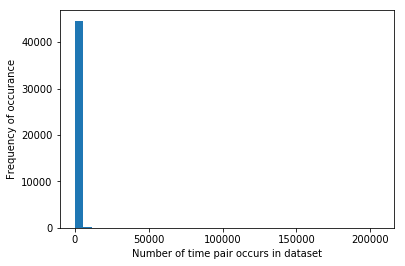

In [23]:
plt.hist(pairs_count['frequency'], bins=35)
plt.xlabel('Number of time pair occurs in dataset')
plt.ylabel('Frequency of occurance')

Whew, this dataset is varied! We definitely want our minimum threshold to be below 200,000 (min=200,000)

Are the pairs that occur frequently likely to have higher or lower latency?

Text(0.5,0,'IP pair frequency of occurance')

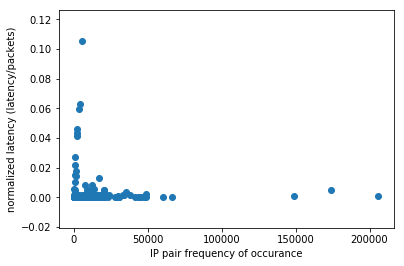

In [24]:
plt.scatter(pairs_count['frequency'], pairs_count['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.02)

Let's pick a few minimum thresholds for testing purposes, let's say we want to make rules based on the top 10%, 20%, 30%, and 40% of IP pairs.

We will create percentiles and find out what percent this equates to, this percentage will then be our 'minimum support threshold' in the model.

In [26]:
per_40=np.percentile(pairs_count['frequency'], [40])

array([23.])

In [27]:
per_80=np.percentile(pairs_count['frequency'], [80])

array([126.])

In [28]:
patterns = pyfpgrowth.find_frequent_patterns(data_l, per_80) 
#we set the min threshold of frequency occurance equal to the 80th percentile of frequency, this will only return results where the pair exists above the 80th percentile, a relatively small amount

In [29]:
confidence=0.7 #this means the rule is likely to be true 70% of the time, it is a high threshold, used for testing
rules = pyfpgrowth.generate_association_rules(patterns, confidence)

In [30]:
len(rules)

329

In [31]:
patterns40=pyfpgrowth.find_frequent_patterns(data_l, per_40)

In [32]:
rules40= pyfpgrowth.generate_association_rules(patterns40, confidence)

In [33]:
len(rules40)

1681

### Generate Rules from the most frequent items we found

Bring in the frequency of each rule and sum of the normalized latency. Use these metrics to prioritize the rules we will implement. There is always a tradeoff withh implementing more rules, so we want to be efficient.

In [34]:
type(rules)

dict

In [35]:
rules

{('10030_137',): (('192.168.210.49',), 1.0),
 ('14594_192',): (('192.168.220.51',), 1.0),
 ('10759_43',): (('192.168.220.47',), 1.0),
 ('13085_24',): (('192.168.220.49',), 1.0),
 ('14154_89',): (('192.168.210.54',), 1.0),
 ('14155_88',): (('192.168.210.54',), 1.0),
 ('10708_220',): (('192.168.220.43',), 1.0),
 ('11513_244',): (('192.168.220.47',), 1.0),
 ('13972_11',): (('192.168.220.48',), 1.0),
 ('10731_186',): (('192.168.220.47',), 1.0),
 ('12468_200',): (('192.168.220.50',), 1.0),
 ('12088_61',): (('192.168.220.51',), 1.0),
 ('10057_27',): (('192.168.220.43',), 1.0),
 ('14620_188',): (('192.168.210.48',), 1.0),
 ('12688_140',): (('192.168.220.51',), 1.0),
 ('10088_242',): (('192.168.220.48',), 1.0),
 ('10085_11',): (('192.168.220.51',), 1.0),
 ('10650_38',): (('192.168.220.47',), 1.0),
 ('10123_77',): (('192.168.220.42',), 1.0),
 ('10088_247',): (('192.168.220.46',), 1.0),
 ('10510_126',): (('192.168.220.51',), 1.0),
 ('14582_235',): (('192.168.220.43',), 1.0),
 ('11841_162',): (('

In [36]:
#Convert the Dictionary format into a dataframe
rules_df=pd.DataFrame(list(rules.items()), columns=['IP_A', 'confidence'])
rules_df['confidence']=rules_df['confidence'].astype(str)

rules_df['IP_B'], rules_df['B'] = rules_df['confidence'].str.split(', ', 1).str
rules_df=rules_df.drop('confidence', axis=1)
rules_df.IP_B=rules_df.IP_B.astype(str)
rules_df.IP_A=rules_df.IP_A.astype(str)
rules_df.columns=['IP_A', 'IP_B', 'confidence']
rules_df[['IP_A', 'IP_B']]=rules_df[['IP_A', 'IP_B']].replace({',':''}, regex=True)

rules_df['IP_A'] = rules_df['IP_A'].map(lambda x: x.lstrip('(').rstrip(')'))
rules_df['IP_B'] = rules_df['IP_B'].map(lambda x: x.lstrip('((').rstrip(')'))
rules_df['confidence'] = rules_df['confidence'].map(lambda x: x.rstrip(')'))
rules_df['IP_A'] = rules_df['IP_A'].map(lambda x: x.lstrip("'").rstrip("'"))
rules_df['IP_B'] = rules_df['IP_B'].map(lambda x: x.lstrip("'").rstrip("'"))

In [37]:
#add back in a pairs column, this is important because the order of IP_A and IP_B does not matter, 
rules_df['pairs']=list(zip(rules_df.IP_A, rules_df.IP_B))
rules_df['pairs']=rules_df['pairs'].apply(sorted)
rules_df['pairs2']=tuple(rules_df['pairs'])

Add back in the normalized latency and frequency of occurance into this rules dataframe.

In [38]:
rules_df=rules_df.merge(pairs_count, left_on='pairs2', right_on='pairs')

In [39]:
rules_df=rules_df.drop('pairs_y', axis=1)
rules_df=rules_df.rename(columns={'pairs_x':'pairs'})
rules_df.head()

IP_A            IP_B confidence                        pairs  \
0  10030_137  192.168.210.49        1.0  [10030_137, 192.168.210.49]   
1  14594_192  192.168.220.51        1.0  [14594_192, 192.168.220.51]   
2   10759_43  192.168.220.47        1.0   [10759_43, 192.168.220.47]   
3   13085_24  192.168.220.49        1.0   [13085_24, 192.168.220.49]   
4   14154_89  192.168.210.54        1.0   [14154_89, 192.168.210.54]   

                        pairs2  frequency  avg_norm_latency  total_duration  \
0  (10030_137, 192.168.210.49)        126          0.005588          13.268   
1  (14594_192, 192.168.220.51)        126          0.023760          16.016   
2   (10759_43, 192.168.220.47)        128          0.004098           1.416   
3   (13085_24, 192.168.220.49)        128          0.029191          25.497   
4   (14154_89, 192.168.210.54)        128          0.007364           7.290   

   total_packets  norm_latency  
0            463  7.259393e-06  
1            311  8.762921e-06  
2            414  7.747437e-07  
3           1608  1.395031e-05  
4            244  3.988617e-06

### now plot the normalized latency vs frequency and see if we have any trends

Text(0.5,0,'IP pair frequency of occurance')

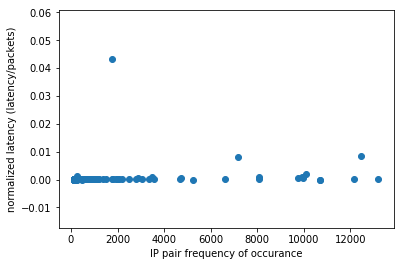

In [40]:
plt.scatter(rules_df['frequency'], rules_df['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.015)

#### Comparing this plot to the earlier plot of all IP pairs, we see two things:
    1. the left arm on the plot with all datapoints at the x-axis=0 is gone, this indicates that the model did not allow IP pairs with very low frequency. This is intuitive because of the min threshold we set for 'support' (which is simply frequency) equal to xx.
    2. The x-axis is significantly shorter than the plot with all datapoints. This is due to the 'confidence' threshold we selected when creating the rules. This means that it is hard for the model to be as certain that an IP is likely to co-occur at higher frequency. This is counter intuitive, but is likely explained by the definition of confidience: frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. Even if a pair has a high frequency of occuring, the frequency of X alone might be so great that it drowns out the signal of detecting the pair.
    

### rank these based on these trends... see how time cumulates as rank goes up, do we reach a threshold?

Simple ranking approach:
    Multiply the pair frequency of occurance by the normal latency duration time for that pair. We are simply giving higher priority to pairs that are slow, so even if they are not that frequent they will still be ranked higher because we have more to gain by co-locating them and reducing latency. 
    
    for example if pair A appears 100 times, and has a normal latency of 0.005 it's score = 100*0.005 = 0.5
    if a pair B appears 100 times, and has a normal latency of 0.02, it's score = 100/0.02 = 2.0
    
    Pair B is given a higher score (rank) than Pair A, even though they both had the same frequency, pair B is prioritized because it is slow and costs us time and money. Let's get them co-located!

In [47]:
100*0.02

2.0

In [48]:
rules_df['latency_rank']=rules_df['frequency']*rules_df['norm_latency']

In [51]:
rules_df=rules_df.sort_values(by='latency_rank', ascending=False)
rules_df

IP_A            IP_B          confidence  \
326       13053_118  192.168.210.56                 1.0   
299       13049_193  192.168.210.56                 1.0   
317       13053_106  192.168.210.56                 1.0   
322        10272_44  192.168.220.51                 1.0   
319        14170_51  192.168.220.51                 1.0   
327  192.168.100.14  192.168.220.51  0.7689569792633859   
321   192.168.100.2  192.168.220.51  0.9885708606638839   
320   192.168.100.1  192.168.220.51                 1.0   
325       12087_137  192.168.220.47                 1.0   
310       11685_203  192.168.210.53  0.9769274057400112   
307        11714_20  192.168.210.53  0.9656796769851952   
318       14185_238  192.168.220.51                 1.0   
314       11681_180  192.168.210.54  0.9963998305802626   
328   192.168.220.1  192.168.220.51  0.9861764925651947   
306         10692_1  192.168.220.43  0.8405405405405405   
316        14172_51  192.168.220.51                 1.0   
308        10763_18  192.168.220.51  0.9253139458030403   
180        13379_49  192.168.220.48                 1.0   
301       14184_244  192.168.220.51  0.9773510585918267   
312        10597_84  192.168.220.51  0.8470139771283355   
284       13184_115  192.168.210.49                 1.0   
303        10123_41  192.168.220.51   0.938568129330254   
287       12486_238  192.168.210.52                 1.0   
302        10123_71  192.168.220.51   0.943952802359882   
305        10597_79  192.168.220.51  0.8004631416441529   
311        13047_59  192.168.210.56  0.9821182943603851   
283       11752_128  192.168.220.47  0.9544910179640719   
280       10154_212  192.168.220.51  0.9765013054830287   
300       13035_162  192.168.220.51  0.9894911504424779   
304        10123_37  192.168.220.51  0.9674439067311923   
..              ...             ...                 ...   
12         10057_27  192.168.220.43                 1.0   
75        11701_221  192.168.220.51  0.7678571428571429   
172        10981_41  192.168.220.51  0.7377049180327869   
90         12571_92  192.168.220.47  0.7640449438202247   
97        12803_143  192.168.220.51  0.9005524861878453   
40          13600_4  192.168.220.51    0.87248322147651   
84        11698_111  192.168.220.45   0.861271676300578   
160        10088_36  192.168.220.47  0.8325991189427313   
6         10708_220  192.168.220.43                 1.0   
5          14155_88  192.168.210.54                 1.0   
85        10320_211  192.168.220.51  0.7586206896551724   
138       10698_157  192.168.210.55  0.9805825242718447   
20        10510_126  192.168.220.51                 1.0   
4          14154_89  192.168.210.54                 1.0   
154        10045_94  192.168.210.54  0.7058823529411765   
100       10013_240  192.168.220.47  0.8011049723756906   
324   192.168.220.2  192.168.220.51   0.966078697421981   
19        10088_247  192.168.220.46                 1.0   
10        12468_200  192.168.220.50                 1.0   
25        10016_144  192.168.220.51                 1.0   
166       10001_210  192.168.220.51  0.8103448275862069   
26         12469_84  192.168.220.47                 1.0   
16         10085_11  192.168.220.51                 1.0   
51         10003_90  192.168.220.47                 1.0   
141        11585_52  192.168.220.45  0.7904761904761904   
2          10759_43  192.168.220.47                 1.0   
41        10297_248  192.168.220.51  0.9333333333333333   
315   192.168.200.2  192.168.220.51                 1.0   
323   192.168.210.1  192.168.220.51   0.969532100108814   
194       13831_172  192.168.220.48                 1.0   

                                pairs                            pairs2  \
326       [13053_118, 192.168.210.56]       (13053_118, 192.168.210.56)   
299       [13049_193, 192.168.210.56]       (13049_193, 192.168.210.56)   
317       [13053_106, 192.168.210.56]       (13053_106, 192.168.210.56)   
322        [10272_44, 192.168.220.51]        (10272_44, 

## Assign Servers to each IP address in the rules dataframe

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

In [76]:
#1. Start by filling in the servers on the pairs until the server is full
import math
apps_server=20 #number of apps that can fit on each server, arbitrary pick
pairs_server=apps_server/2 #pairs of IP addresses that can fit on each server

#how many servers do we need for our rules, which are in pairs?
servers_rule=math.ceil(len(rules_df)/pairs_server)

servers_rule_list=list(range(0,servers_rule+1))
servers_rule_list=np.repeat(servers_rule_list,pairs_server)

#remove the extra items
servers_rule_list=servers_rule_list[0:len(rules_df)]

In [113]:
xx=int(math.ceil(len(rules_df)/2))
xxlist=list(range(0,xx))

In [114]:
pairids=np.repeat(xxlist,2)
pairids=pairids[0:len(rules_df)]

In [117]:
# add a pair_ID column so we can keep track of how frequently IP addresses repeat in different pairs
rules_df['pair_ID']=pairids

In [123]:
rules_df.head()

IP_A            IP_B confidence                        pairs  \
326  13053_118  192.168.210.56        1.0  [13053_118, 192.168.210.56]   
299  13049_193  192.168.210.56        1.0  [13049_193, 192.168.210.56]   
317  13053_106  192.168.210.56        1.0  [13053_106, 192.168.210.56]   
322   10272_44  192.168.220.51        1.0   [10272_44, 192.168.220.51]   
319   14170_51  192.168.220.51        1.0   [14170_51, 192.168.220.51]   

                          pairs2  frequency  avg_norm_latency  total_duration  \
326  (13053_118, 192.168.210.56)      12439          0.255143       15736.067   
299  (13049_193, 192.168.210.56)       1775          0.372031       79345.558   
317  (13053_106, 192.168.210.56)       7180          0.343261       14717.209   
322   (10272_44, 192.168.220.51)      10094          0.091117        3665.353   
319   (14170_51, 192.168.220.51)       8094          0.022052        1881.134   

     total_packets  norm_latency  latency_rank  server  pair_ID  
326          44427      0.008610    107.096797       0        0  
299         245786      0.043413     77.057656       0        0  
317          31305      0.008052     57.815558       0        1  
322          26275      0.002005     20.242956       0        1  
319          26460      0.001029      8.330628       0        2

find out how many pair ids exist in each individual IP

In [131]:
#how many unique IPs in A?

rules_df['IP_A'].nunique()

329

This is the entire dataset, which indicates that all IP_As are unique!
We do have repeats in IP_B, so need to deal with those

In [130]:
rules_df.groupby('IP_B')['pair_ID'].apply(list)

IP_B
192.168.100.20                                                 [16]
192.168.210.45                          [37, 43, 47, 108, 116, 134]
192.168.210.46                                                 [42]
192.168.210.47                    [34, 44, 55, 75, 76, 80, 95, 142]
192.168.210.48                              [45, 91, 101, 107, 124]
192.168.210.49                                        [10, 40, 141]
192.168.210.50                                             [30, 51]
192.168.210.52                                             [11, 80]
192.168.210.53           [4, 5, 61, 66, 74, 79, 106, 114, 116, 143]
192.168.210.54    [6, 32, 38, 48, 54, 59, 81, 103, 122, 130, 154...
192.168.210.55                             [84, 107, 117, 135, 155]
192.168.210.56     [0, 0, 1, 12, 24, 33, 70, 83, 83, 103, 139, 145]
192.168.210.57                          [33, 40, 71, 120, 122, 147]
192.168.220.42    [31, 31, 58, 71, 72, 90, 93, 98, 110, 120, 128...
192.168.220.43    [7, 57, 73, 111, 118, 123

In [125]:
g=rules_df.groupby('IP_A')

In [128]:
g.groups.keys()

dict_keys(['10001_210', '10003_106', '10003_162', '10003_235', '10003_51', '10003_90', '10011_132', '10013_240', '10016_144', '10021_188', '10022_144', '10022_207', '10030_137', '10030_147', '10030_163', '10030_164', '10045_202', '10045_94', '10054_151', '10057_27', '10057_64', '10058_130', '10058_69', '10067_13', '10067_144', '10072_35', '10085_11', '10085_147', '10088_156', '10088_187', '10088_191', '10088_208', '10088_216', '10088_234', '10088_242', '10088_247', '10088_36', '10088_44', '10088_98', '10097_80', '10104_80', '10105_203', '10123_37', '10123_41', '10123_51', '10123_71', '10123_77', '10124_53', '10138_76', '10154_212', '10158_229', '10160_81', '10162_190', '10166_37', '10189_113', '10234_57', '10244_145', '10272_11', '10272_44', '10286_163', '10288_211', '10288_80', '10297_248', '10302_128', '10302_64', '10320_211', '10343_180', '10351_135', '10407_81', '10416_100', '10416_76', '10459_241', '10471_133', '10501_102', '10502_23', '10510_126', '10545_93', '10556_0', '10557_12

In [119]:
#melt the IPA and IPB with rank so we can step through them 
rules_melt=pd.melt(rules_df, id_vars=['latency_rank', 'pair_ID'], value_vars=['IP_A','IP_B'])

In [120]:
rules_melt=rules_melt.sort_values(by='latency_rank', ascending=False)
rules_melt=rules_melt.rename(columns={'value':'IP'})

In [121]:
rules_melt.head()

latency_rank  pair_ID variable              IP
0      107.096797        0     IP_A       13053_118
329    107.096797        0     IP_B  192.168.210.56
330     77.057656        0     IP_B  192.168.210.56
1       77.057656        0     IP_A       13049_193
331     57.815558        1     IP_B  192.168.210.56

In [68]:
rules_melt=rules_melt.drop_duplicates('IP')

In [118]:
#assign these servers to the pairs in our rules dataframe. Again this is stupid as we are not considering individual IPs that may repeat in different pairs. but it's a start
rules_df['server']=servers_rule_list
rules_df.head()

IP_A            IP_B confidence                        pairs  \
326  13053_118  192.168.210.56        1.0  [13053_118, 192.168.210.56]   
299  13049_193  192.168.210.56        1.0  [13049_193, 192.168.210.56]   
317  13053_106  192.168.210.56        1.0  [13053_106, 192.168.210.56]   
322   10272_44  192.168.220.51        1.0   [10272_44, 192.168.220.51]   
319   14170_51  192.168.220.51        1.0   [14170_51, 192.168.220.51]   

                          pairs2  frequency  avg_norm_latency  total_duration  \
326  (13053_118, 192.168.210.56)      12439          0.255143       15736.067   
299  (13049_193, 192.168.210.56)       1775          0.372031       79345.558   
317  (13053_106, 192.168.210.56)       7180          0.343261       14717.209   
322   (10272_44, 192.168.220.51)      10094          0.091117        3665.353   
319   (14170_51, 192.168.220.51)       8094          0.022052        1881.134   

     total_packets  norm_latency  latency_rank  server  pair_ID  
326          44427      0.008610    107.096797       0        0  
299         245786      0.043413     77.057656       0        0  
317          31305      0.008052     57.815558       0        1  
322          26275      0.002005     20.242956       0        1  
319          26460      0.001029      8.330628       0        2

In [ ]:
Because a server can only hold so many apps, and this capacity is an even number, it ensures pairs 

------------- 
Try and assign pair values, and also find the other pair ids that are repeated in the IP pair